In [ ]:
pip install pycaret

In [1]:
#@title Imports e montagem do drive


import numpy as np
import pandas as pd
# import itertools
import math

import seaborn as sns


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pycaret.regression import *

#show all columns
pd.set_option('display.max_columns', None)

# Carrega o driver e monta para o notebook
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive", force_remount=True)

raiz_pasta = "drive/My Drive/Iveco_Interno/Analises_e_Modelos/Analise_Precificacao/"

Mounted at /content/drive


In [ ]:
#base_pesados =
base_analitica_pesados = pd.read_csv(raiz_pasta + "base_analitica_pesados.csv"
                            #  ,sheet_name='CLAIM (H)'
                            #  ,usecols = list(dict_dtypes.keys()) + parse_dates
                            #  ,dtype = dict_dtypes
                            #  ,parse_dates=parse_dates                              
                            )
base_analitica_pesados.loc[base_analitica_pesados['Contract Number'].isna() , 'Contract Number'] = 4330331070.0

base_analitica_pesados['Contract Number'] = base_analitica_pesados['Contract Number'].astype(int).astype(str)

#4330331070

base_analitica_pesados

Repair Market Description Dealer Claim Number  Workshop Sap Code  \
0                       Brazil              161309              25752   
1                       Brazil              170245              25752   
2                       Brazil              170245              25752   
3                       Brazil              170370              25752   
4                       Brazil              170370              25752   
...                        ...                 ...                ...   
6794                    Brazil              220452             116145   
6795                    Brazil              220452             116145   
6796                    Brazil              220452             116145   
6797                    Brazil              223033              48597   
6798                    Brazil              220742             142416   

     Warranty Type Code  Failure Code Workshop Date IN Workshop Date OUT  \
0                     R        766122       2016-12-01        2016-12-01   
1                     R        507410       2017-05-18        2017-05-19   
2                     R        553212       2017-05-18        2017-05-19   
3                     R        500456       2017-07-05        2017-07-10   
4                     R        540452       2017-07-05        2017-07-10   
...                 ...           ...              ...               ...   
6794                  R        501469       2022-07-29        2022-08-03   
6795                  R        769110       2022-07-29        2022-08-03   
6796                  R        798510       2022-07-29        2022-08-03   
6797                  R        543070       2022-07-08        2022-07-08   
6798                  R        773110       2022-08-08        2022-08-08   

     Warranty Start Date Payment Date  Work Unit Approved  \
0             2015-06-19   2016-12-10                7.00   
1             2015-06-19   2017-05-27               41.25   
2             2015-06-19   2017-05-27                3.00   
3             2015-06-19   2017-07-22               58.00   
4             2015-06-19   2017-07-22                8.00   
...                  ...          ...                 ...   
6794          2022-02-24   2022-08-06                5.00   
6795          2022-02-24   2022-08-06               30.00   
6796          2022-02-24   2022-08-06                4.00   
6797          2022-02-24   2022-07-16                2.00   
6798          2022-05-19   2022-08-20                6.00   

      Approved Amount Material (Local)  Approved Amount Labor (Local)  \
0                               418.66                         107.66   
1                              4232.37                         634.43   
2                               582.13                          46.14   
3                               166.23                         892.04   
4                                31.44                         123.04   
...                                ...                            ...   
6794                            152.88                         117.50   
6795                              0.00                         705.00   
6796                            488.92                          94.00   
6797                            131.00                          42.36   
6798                            463.38                          73.98   

      Approved Amount External Work (Local)  Approved Amount (Local)  \
0                                       0.0                   526.32   
1                                       0.0                  4866.80   
2                                       0.0                   628.27   
3                                       0.0                  1058.27   
4                                       0.0                   154.48   
...                                     ...                      ...   
6794                                    0.0                   270.38   
6795                         

In [ ]:
base_analitica_pesados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Repair Market Description              6799 non-null   object 
 1   Dealer Claim Number                    6799 non-null   object 
 2   Workshop Sap Code                      6799 non-null   int64  
 3   Warranty Type Code                     6799 non-null   object 
 4   Failure Code                           6799 non-null   int64  
 5   Workshop Date IN                       6799 non-null   object 
 6   Workshop Date OUT                      6799 non-null   object 
 7   Warranty Start Date                    6799 non-null   object 
 8   Payment Date                           6799 non-null   object 
 9   Work Unit Approved                     6799 non-null   float64
 10  Approved Amount Material (Local)       6799 non-null   float64
 11  Appr

In [ ]:
aux_1 = base_analitica_pesados.groupby(by=['Vin Code','Contract Number','Commercial Range Current Description','MISSÃO']).agg({ #'Workshop Date IN': pd.Series.nunique,
                                               # 'Failure Code': 'count',
                                                'Preco_atualizado': 'sum', #usa o máx para não haver duplicidade
                                                'Preco_atualizado_falha': 'sum', #usa o máx para não haver duplicidade
                                                'Vehicle Km': 'max',
                                                'Approved Amount (Local)': 'sum'
                                               }).reset_index(drop=False)

aux_1.rename(columns={'Approved Amount (Local)': 'Preco' }, inplace=True)
aux_1

Vin Code Contract Number Commercial Range Current Description  \
0    93ZM1USH0F8828662      4330325658                     L.A.-STRALIS 4X2   
1    93ZM1USH0F8828663      4330325659                     L.A.-STRALIS 4X2   
2    93ZM1USH0F8828664      4330325660                     L.A.-STRALIS 4X2   
3    93ZM2SSH0F8828329      4330324117                     L.A.-STRALIS 6X2   
4    93ZM2SSH0F8828502      4330327316                     L.A.-STRALIS 6X2   
5    93ZM2SSH0F8828617      4330327315                     L.A.-STRALIS 6X2   
6    93ZM2SSH0F8828625      4330326629                     L.A.-STRALIS 6X2   
7    93ZM2SSH0F8828628      4330327317                     L.A.-STRALIS 6X2   
8    93ZM2SSH0F8828689      4330326628                     L.A.-STRALIS 6X2   
9    93ZM2SSH0H8828841      4330327382                     L.A.-STRALIS 6X2   
10   93ZM2SSH0H8829053      4330329238                     L.A.-STRALIS 6X2   
11   93ZM2SSH0H8829056      4330329241                     L.A.-STRALIS 6X2   
12   93ZM2SSH0H8829060      4330329239                     L.A.-STRALIS 6X2   
13   93ZM2SSH0H8829063      4330329240                     L.A.-STRALIS 6X2   
14   93ZM2SSH0H8829079      4330333196                     L.A.-STRALIS 6X2   
15   93ZM2SSH0H8829079      4330343477                     L.A.-STRALIS 6X2   
16   93ZM2SSH0J8830114      4330333717                     L.A.-STRALIS 6X2   
17   93ZM2SSH0K8831061      4330333828                     L.A.-STRALIS 6X2   
18   93ZM2SSH0K8831061      4330347620                     L.A.-STRALIS 6X2   
19   93ZM2SSH0K8831140      4330333829                     L.A.-STRALIS 6X2   
20   93ZM2SSH0K8831140      4330348564                     L.A.-STRALIS 6X2   
21   93ZM2SSH0K8831250      4330334155                     L.A.-STRALIS 6X2   
22   93ZM2SSH0K8831332      4330334156                     L.A.-STRALIS 6X2   
23   93ZM2SSH0K8831335      4330334160                     L.A.-STRALIS 6X2   
24   93ZM2SSH0K8831345      4330334159                     L.A.-STRALIS 6X2   
25   93ZM2SSH0K8831349      4330334157                     L.A.-STRALIS 6X2   
26   93ZM2SSH0K8831362      4330334158                     L.A.-STRALIS 6X2   
27   93ZM2SSH0K8831373      4330336589                     L.A.-STRALIS 6X2   
28   93ZM2SSH0K8831461      4330334161                     L.A.-STRALIS 6X2   
29   93ZM2SSH0K8831468      4330334162                     L.A.-STRALIS 6X2   
30   93ZM2SSH0K8831520      4330334471                     L.A.-STRALIS 6X2   
31   93ZM2SSH0K8831524      4330334472                     L.A.-STRALIS 6X2   
32   93ZM2SSH0K8831786      4330335786                     L.A.-STRALIS 6X2   
33   93ZM2SSH0K8831796      4330335784                     L.A.-STRALIS 6X2   
34   93ZM2SSH0K8831802      4330335782                     L.A.-STRALIS 6X2   
35   93ZM2SSH0K8831814      4330335563                     L.A.-STRALIS 6X2   
36   93ZM2SSH0K8831855      4330335783                     L.A.-STRALIS 6X2   
37   93ZM2SSH0K8831900      4330335788                     L.A.-STRALIS 6X2   
38   93ZM2SSH0K8831912      4330335787                     L.A.-STRALIS 6X2   
39   93ZM2SSH0K8831915      4330335779                     L.A.-STRALIS 6X2   
40   93ZM2SSH0K8831924      4330335790                     L.A.-STRALIS 6X2   
41   93ZM2SSH0K8831925      4330335785                     L.A.-STRALIS 6X2   
42   93ZM2SSH0K8831927      4330335789                     L.A.-STRALIS 6X2   
43   93ZM2SSH0L8832585      4330335270                     L.A.-STRALIS 6X2   
44   93ZM2SSH0L8832633      4330335271                     L.A.-STRALIS 6X2   
45   93ZM2SSH0L8833002      4330335527                     L.A.-STRALIS 6X2   
46   93ZM2SSH0L8833236      4330339524                     L.A.-STRALIS 6X2   
47   93ZM2SSH0L8833245      4330336553                     L.A.-STRALIS 6X2   
48   93ZM2SSH0L8833285      4330339522                     L.A.-STRALIS 6X2   
49   93ZM2SSH0L8833290      4330339521                     L.A.-

In [ ]:
aux_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Vin Code                              488 non-null    object 
 1   Contract Number                       488 non-null    object 
 2   Commercial Range Current Description  488 non-null    object 
 3   MISSÃO                                488 non-null    object 
 4   Preco_atualizado                      488 non-null    float64
 5   Preco_atualizado_falha                488 non-null    float64
 6   Vehicle Km                            488 non-null    float64
 7   Preco                                 488 non-null    float64
dtypes: float64(4), object(4)
memory usage: 30.6+ KB


Chamando a base de contratos para extrair o período contratado (qnd meses), o percentual de uso do contrato (percentage of life) e então calcular meses decorridos desde o início do contrato. 

In [ ]:
 aux_2 = pd.read_excel("drive/My Drive/Iveco_Interno/Analises_e_Modelos/Bases_de_Dados/Planilhas Novembro/Abaco Details Daily - Contract Only CSV.xlsx"
                                ,sheet_name='Daily Abaco - Details_1'
                                ,usecols="A,Q,R,T,Z"
                                ,skiprows =18
                              #  ,names = ["Failure Code", "Peso_da_falha"]
                              # ,keep_default_na=False
                                )
 aux_2.dropna(axis = 0, how = 'all', inplace = True)
 aux_2['Contract Number'] =  aux_2['Contract Number'].astype(int).astype(str)


 aux_2

Contract Number  Contract Period  Percentage of Life  Initial Km  \
0          4330335464             29.0              0.0000         0.0   
1          4330353796             24.0              0.3946         0.0   
2          4330340792             12.0              0.0000         0.0   
3          4330330515             24.0              0.0000    194358.0   
4          4330334370             24.0              0.0000         0.0   
...               ...              ...                 ...         ...   
36839      4310002173             12.0              0.0000         0.0   
36840      4310002080             12.0              0.0000         0.0   
36841      4310003537             60.0              0.1178         0.0   
36842      4310001738              8.0              0.0000         0.0   
36843      4310000822             24.0              0.0000         0.0   

      Vehicle Identification Number (VIN)  
0                       93ZC35B01K8484282  
1                       93ZM2SSH0N8838238  
2                       93ZA01BDZM8939310  
3                       93ZS3HUH0E8828192  
4                       93ZC0359ZK8484288  
...                                   ...  
36839                   8ATA1RMH0JX106088  
36840                   8ATA1RMH0KX109932  
36841                   8ATM1RMH0NX117193  
36842                   93ZK53C01K8482001  
36843                   93ZL72C01H8473232  

[36844 rows x 5 columns]

In [ ]:
aux_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36844 entries, 0 to 36843
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Contract Number                      36844 non-null  object 
 1   Contract Period                      36844 non-null  float64
 2   Percentage of Life                   36844 non-null  float64
 3   Initial Km                           36844 non-null  float64
 4   Vehicle Identification Number (VIN)  36844 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.7+ MB


In [ ]:
## Para a categoria 4x2 temos apenas 3 veículos e todos eles não possuem dados de contrato completos. 

#aux[aux['Commercial Range Current Description'] == 'L.A.-STRALIS 4X2']

Vin Code Contract Number Commercial Range Current Description  \
0  93ZM1USH0F8828662      4330325658                     L.A.-STRALIS 4X2   
1  93ZM1USH0F8828663      4330325659                     L.A.-STRALIS 4X2   
2  93ZM1USH0F8828664      4330325660                     L.A.-STRALIS 4X2   

       MISSÃO  Preco_atualizado  Vehicle Km  Initial Km  Gasto_mensal  
0  Rodoviário         1986.7925    160263.0         0.0           NaN  
1  Rodoviário         1258.9425    159998.0         0.0           NaN  
2  Rodoviário         4865.0550    174150.0         0.0           NaN

In [ ]:
aux = pd.merge(aux_1, aux_2, how="left", on=["Contract Number"])
aux.dropna(subset = ['Contract Period'], inplace=True)
aux.reset_index(drop=True,inplace=True)

### aux['Vin Code'].equals(aux['Vehicle Identification Number (VIN)']) = True

### Existem 3 casos para 4x2
# aux.loc[aux['Commercial Range Current Description'] == 'L.A.-STRALIS 4X2' , 'Initial Km'] = 0.0


aux['Uso_do_contrato'] = aux['Contract Period']*(1- aux['Percentage of Life'])


aux['Gasto_mensal_falha'] = aux['Preco_atualizado_falha'] / aux['Uso_do_contrato']
aux['Gasto_mensal_atualizado'] = aux['Preco_atualizado'] / aux['Uso_do_contrato']
aux['Gasto_mensal'] = aux['Preco'] / aux['Uso_do_contrato']

aux.drop(['Vehicle Identification Number (VIN)',
         # 'Preco_atualizado_falha',
          'Contract Period',
          'Percentage of Life',	
          'Uso_do_contrato'], axis=1, inplace=True)


# aux

## Adequando a base para criar o modelo

In [ ]:
aux['Km_percorrido'] = aux['Vehicle Km'] - aux['Initial Km']

aux['Preco_Km_percorrido'] = aux['Preco'] / aux['Km_percorrido']
aux['Preco_Km_atualizado'] = aux['Preco_atualizado'] / aux['Km_percorrido']
aux['Preco_Km_falha'] = aux['Preco_atualizado_falha'] / aux['Km_percorrido']

base = aux[['Commercial Range Current Description','MISSÃO',
            'Vehicle Km','Initial Km','Km_percorrido',
            'Preco','Preco_atualizado','Preco_atualizado_falha',
            'Preco_Km_percorrido','Preco_Km_atualizado','Preco_Km_falha',
            'Gasto_mensal','Gasto_mensal_atualizado','Gasto_mensal_falha']].copy()

base.rename(columns={'Initial Km':'Km_inicial',
                            'Vehicle Km':"Km_atual",
                            'MISSÃO': 'Missao',
                            'Commercial Range Current Description': 'Tipo_veiculo'
                            }, inplace=True)

base['Tipo_veiculo'] = base['Tipo_veiculo'].astype('category')
base['Missao'] = base['Missao'].astype('category')

base.to_csv(raiz_pasta + "base_analitica_precificacao.csv",index=False)

#base

In [4]:
base = pd.read_csv(raiz_pasta + "base_analitica_precificacao.csv")


base

Tipo_veiculo      Missao  Km_atual  Km_inicial  Km_percorrido  \
0    L.A.-STRALIS 6X2      Severo  279727.0         0.0       279727.0   
1    L.A.-STRALIS 6X2  Rodoviário  563144.0         1.0       563143.0   
2    L.A.-STRALIS 6X2  Rodoviário  599721.0         1.0       599720.0   
3    L.A.-STRALIS 6X2      Severo  351630.0         0.0       351630.0   
4    L.A.-STRALIS 6X2  Rodoviário  546802.0         1.0       546801.0   
5    L.A.-STRALIS 6X2      Severo  301203.0         0.0       301203.0   
6    L.A.-STRALIS 6X2      Severo  309996.0         0.0       309996.0   
7    L.A.-STRALIS 6X2  Rodoviário  359766.0         0.0       359766.0   
8    L.A.-STRALIS 6X2  Rodoviário  355996.0         0.0       355996.0   
9    L.A.-STRALIS 6X2  Rodoviário  344339.0         0.0       344339.0   
10   L.A.-STRALIS 6X2  Rodoviário  350142.0         0.0       350142.0   
11   L.A.-STRALIS 6X2  Rodoviário  499652.0    201000.0       298652.0   
12   L.A.-STRALIS 6X2  Rodoviário  706207.0    515800.0       190407.0   
13   L.A.-STRALIS 6X2  Rodoviário  408775.0         0.0       408775.0   
14   L.A.-STRALIS 6X2  Rodoviário  359048.0         0.0       359048.0   
15   L.A.-STRALIS 6X2  Rodoviário  482701.0    360011.0       122690.0   
16   L.A.-STRALIS 6X2  Rodoviário  361800.0         0.0       361800.0   
17   L.A.-STRALIS 6X2  Rodoviário  510680.0    361895.0       148785.0   
18   L.A.-STRALIS 6X2  Rodoviário  362984.0         0.0       362984.0   
19   L.A.-STRALIS 6X2  Rodoviário  363912.0         0.0       363912.0   
20   L.A.-STRALIS 6X2  Rodoviário  367949.0         0.0       367949.0   
21   L.A.-STRALIS 6X2  Rodoviário  360453.0         0.0       360453.0   
22   L.A.-STRALIS 6X2  Rodoviário  374640.0         0.0       374640.0   
23   L.A.-STRALIS 6X2  Rodoviário  357048.0         0.0       357048.0   
24   L.A.-STRALIS 6X2  Rodoviário  163146.0         0.0       163146.0   
25   L.A.-STRALIS 6X2  Rodoviário  359900.0         0.0       359900.0   
26   L.A.-STRALIS 6X2  Rodoviário  361612.0         0.0       361612.0   
27   L.A.-STRALIS 6X2  Rodoviário  360038.0         0.0       360038.0   
28   L.A.-STRALIS 6X2  Rodoviário  381327.0         0.0       381327.0   
29   L.A.-STRALIS 6X2  Rodoviário   82817.0         0.0        82817.0   
30   L.A.-STRALIS 6X2  Rodoviário  226975.0         0.0       226975.0   
31   L.A.-STRALIS 6X2  Rodoviário  283409.0         0.0       283409.0   
32   L.A.-STRALIS 6X2  Rodoviário  241545.0         0.0       241545.0   
33   L.A.-STRALIS 6X2  Rodoviário  261488.0         0.0       261488.0   
34   L.A.-STRALIS 6X2  Rodoviário  293453.0         0.0       293453.0   
35   L.A.-STRALIS 6X2  Rodoviário  293846.0         0.0       293846.0   
36   L.A.-STRALIS 6X2  Rodoviário  278276.0         0.0       278276.0   
37   L.A.-STRALIS 6X2  Rodoviário  293921.0         0.0       293921.0   
38   L.A.-STRALIS 6X2  Rodoviário  319315.0         0.0       319315.0   
39   L.A.-STRALIS 6X2  Rodoviário  281246.0         0.0       281246.0   
40   L.A.-STRALIS 6X2  Rodoviário  375549.0         0.0       375549.0   
41   L.A.-STRALIS 6X2  Rodoviário  319916.0         0.0       319916.0   
42   L.A.-STRALIS 6X2  Rodoviário  198215.0         0.0       198215.0   
43   L.A.-STRALIS 6X2      Severo  225467.0     32000.0       193467.0   
44   L.A.-STRALIS 6X2  Rodoviário  230190.0         0.0       230190.0   
45   L.A.-STRALIS 6X2      Severo  149629.0        11.0       149618.0   
46   L.A.-STRALIS 6X2      Severo  157304.0        11.0       157293.0   
47   L.A.-STRALIS 6X2      Severo  179930.0        11.0       179919.0   
48   L.A.-STRALIS 6X2      Severo  178981.0        11.0       178970.0   
49   L.A.-STRALIS 6X2  Rodoviário  215501.0     12783.0       202718.0   
50   L.A.-STRALIS 6X2  Rodoviário  241186.0     12783.0       228403.0   
51   L.A.-STRALIS 6X2  Rodoviário  245935.0         0.0       245935.0   
52   L.A.-STRALIS 6X2  Rodoviário  298013.0         0.0       298013.0   
53   L.A.-STR

In [5]:
base.Tipo_veiculo.unique()

array(['L.A.-STRALIS 6X2', 'L.A.-STRALIS 6X4'], dtype=object)

In [6]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Tipo_veiculo             466 non-null    object 
 1   Missao                   466 non-null    object 
 2   Km_atual                 466 non-null    float64
 3   Km_inicial               466 non-null    float64
 4   Km_percorrido            466 non-null    float64
 5   Preco                    466 non-null    float64
 6   Preco_atualizado         466 non-null    float64
 7   Preco_atualizado_falha   466 non-null    float64
 8   Preco_Km_percorrido      466 non-null    float64
 9   Preco_Km_atualizado      466 non-null    float64
 10  Preco_Km_falha           466 non-null    float64
 11  Gasto_mensal             466 non-null    float64
 12  Gasto_mensal_atualizado  466 non-null    float64
 13  Gasto_mensal_falha       466 non-null    float64
dtypes: float64(12), object(2)


In [ ]:
base.describe()

Km_atual     Km_inicial  Km_percorrido          Preco  \
count     466.000000     466.000000     466.000000     466.000000   
mean   192818.418455   23071.427039  169746.991416   25233.132425   
std    134441.609435   70747.544824  129461.245430   40651.083034   
min     15773.000000       0.000000    3165.000000      42.640000   
25%    100160.500000       0.000000   80848.250000    2279.180000   
50%    163425.000000       0.000000  129883.000000   10260.990000   
75%    255759.000000       0.000000  216296.000000   31069.740000   
max    706207.000000  515800.000000  601848.000000  263681.400000   

       Preco_atualizado  Preco_atualizado_falha  Preco_Km_percorrido  \
count        466.000000              466.000000           466.000000   
mean       28110.847138            20207.890402             0.119009   
std        45541.399085            33336.625153             0.141530   
min           37.980000               37.980000             0.000271   
25%         2157.206875             1869.466875             0.021205   
50%        11071.126250             7429.255000             0.071931   
75%        34892.681350            23446.941383             0.163658   
max       294862.294500           249737.840182             1.052898   

       Preco_Km_atualizado  Preco_Km_falha   Gasto_mensal  \
count           466.000000      466.000000     466.000000   
mean              0.137000        0.097224    1226.104221   
std               0.182420        0.125535    5414.239468   
min               0.000241        0.000241       1.776667   
25%               0.021458        0.018051      61.263430   
50%               0.074885        0.054867     318.122326   
75%               0.177346        0.127180    1164.252523   
max               1.705170        1.173211  106161.637205   

       Gasto_mensal_atualizado  Gasto_mensal_falha  
count               466.000000          466.000000  
mean               1331.223547          990.714781  
std                5522.114409         4612.673419  
min                   1.582500            1.582500  
25%                  59.773055           48.791083  
50%                 338.329313          226.940913  
75%                1388.881913          983.862282  
max              106330.006429        91860.497538

Separando os dados para predição

Considerando correções por falhas

In [ ]:
base.columns

Index(['Tipo_veiculo', 'Missao', 'Km_atual', 'Km_inicial', 'Km_percorrido',
       'Preco', 'Preco_atualizado', 'Preco_atualizado_falha',
       'Preco_Km_percorrido', 'Preco_Km_atualizado', 'Preco_Km_falha',
       'Gasto_mensal', 'Gasto_mensal_atualizado', 'Gasto_mensal_falha'],
      dtype='object')

In [7]:
base = base[['Tipo_veiculo', 'Missao', 'Km_inicial', 'Km_percorrido',#'Preco_atualizado_falha',
             'Gasto_mensal_falha']]

In [8]:
base.iloc[:,0:4]

Tipo_veiculo      Missao  Km_inicial  Km_percorrido
0    L.A.-STRALIS 6X2      Severo         0.0       279727.0
1    L.A.-STRALIS 6X2  Rodoviário         1.0       563143.0
2    L.A.-STRALIS 6X2  Rodoviário         1.0       599720.0
3    L.A.-STRALIS 6X2      Severo         0.0       351630.0
4    L.A.-STRALIS 6X2  Rodoviário         1.0       546801.0
5    L.A.-STRALIS 6X2      Severo         0.0       301203.0
6    L.A.-STRALIS 6X2      Severo         0.0       309996.0
7    L.A.-STRALIS 6X2  Rodoviário         0.0       359766.0
8    L.A.-STRALIS 6X2  Rodoviário         0.0       355996.0
9    L.A.-STRALIS 6X2  Rodoviário         0.0       344339.0
10   L.A.-STRALIS 6X2  Rodoviário         0.0       350142.0
11   L.A.-STRALIS 6X2  Rodoviário    201000.0       298652.0
12   L.A.-STRALIS 6X2  Rodoviário    515800.0       190407.0
13   L.A.-STRALIS 6X2  Rodoviário         0.0       408775.0
14   L.A.-STRALIS 6X2  Rodoviário         0.0       359048.0
15   L.A.-STRALIS 6X2  Rodoviário    360011.0       122690.0
16   L.A.-STRALIS 6X2  Rodoviário         0.0       361800.0
17   L.A.-STRALIS 6X2  Rodoviário    361895.0       148785.0
18   L.A.-STRALIS 6X2  Rodoviário         0.0       362984.0
19   L.A.-STRALIS 6X2  Rodoviário         0.0       363912.0
20   L.A.-STRALIS 6X2  Rodoviário         0.0       367949.0
21   L.A.-STRALIS 6X2  Rodoviário         0.0       360453.0
22   L.A.-STRALIS 6X2  Rodoviário         0.0       374640.0
23   L.A.-STRALIS 6X2  Rodoviário         0.0       357048.0
24   L.A.-STRALIS 6X2  Rodoviário         0.0       163146.0
25   L.A.-STRALIS 6X2  Rodoviário         0.0       359900.0
26   L.A.-STRALIS 6X2  Rodoviário         0.0       361612.0
27   L.A.-STRALIS 6X2  Rodoviário         0.0       360038.0
28   L.A.-STRALIS 6X2  Rodoviário         0.0       381327.0
29   L.A.-STRALIS 6X2  Rodoviário         0.0        82817.0
30   L.A.-STRALIS 6X2  Rodoviário         0.0       226975.0
31   L.A.-STRALIS 6X2  Rodoviário         0.0       283409.0
32   L.A.-STRALIS 6X2  Rodoviário         0.0       241545.0
33   L.A.-STRALIS 6X2  Rodoviário         0.0       261488.0
34   L.A.-STRALIS 6X2  Rodoviário         0.0       293453.0
35   L.A.-STRALIS 6X2  Rodoviário         0.0       293846.0
36   L.A.-STRALIS 6X2  Rodoviário         0.0       278276.0
37   L.A.-STRALIS 6X2  Rodoviário         0.0       293921.0
38   L.A.-STRALIS 6X2  Rodoviário         0.0       319315.0
39   L.A.-STRALIS 6X2  Rodoviário         0.0       281246.0
40   L.A.-STRALIS 6X2  Rodoviário         0.0       375549.0
41   L.A.-STRALIS 6X2  Rodoviário         0.0       319916.0
42   L.A.-STRALIS 6X2  Rodoviário         0.0       198215.0
43   L.A.-STRALIS 6X2      Severo     32000.0       193467.0
44   L.A.-STRALIS 6X2  Rodoviário         0.0       230190.0
45   L.A.-STRALIS 6X2      Severo        11.0       149618.0
46   L.A.-STRALIS 6X2      Severo        11.0       157293.0
47   L.A.-STRALIS 6X2      Severo        11.0       179919.0
48   L.A.-STRALIS 6X2      Severo        11.0       178970.0
49   L.A.-STRALIS 6X2  Rodoviário     12783.0       202718.0
50   L.A.-STRALIS 6X2  Rodoviário     12783.0       228403.0
51   L.A.-STRALIS 6X2  Rodoviário         0.0       245935.0
52   L.A.-STRALIS 6X2  Rodoviário         0.0       298013.0
53   L.A.-STRALIS 6X2      Severo        11.0       175635.0
54   L.A.-STRALIS 6X2      Severo        11.0       188510.0
55   L.A.-STRALIS 6X2      Severo        11.0       121679.0
56   L.A.-STRALIS 6X2      Severo        11.0       169381.0
57   L.A.-STRALIS 6X2      Severo        11.0       163749.0
58   L.A.-STRALIS 6X2      Severo        11.0        90114.0
59   L.A.-STRALIS 6X2      Severo        11.0       153216.0
60   L.A.-STRALIS 6X2      Severo        11.0       169000.0
61   L.A.-STRALIS 6X2      Severo        11.0       163693.0
62   L.A.-STRALIS 6X2      Severo        11.0       191715.0
63   L.A.-STRALIS 6X2  Rodoviário         0.0       237574.0
64   L.A.-STRALIS 6X2  Rodoviário        22.

In [ ]:
condition = base['Gasto_mensal_falha'] < 20000
x = base[condition]['Gasto_mensal_falha']
y = base[condition]['Tipo_veiculo']

sns.boxplot(data=base, x=x, y=y);

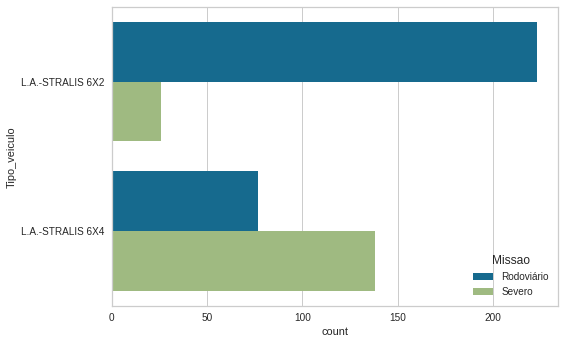

In [ ]:
sns.countplot(data = base[condition], y='Tipo_veiculo', hue="Missao");


In [ ]:
# Temos dois outliers

#Existem dois casos que discrepantes (outliers)
# Um para 6x2 (>100k por mes) e outro para 6x4 (>40k por mes)
condition = base['Gasto_mensal_falha'] < 20000
x = base[condition]['Gasto_mensal_falha']
y = base[condition]['Km_percorrido']

# sns.scatterplot(x, y);

sns.scatterplot(data=base[condition], x=x, y=y, hue="Tipo_veiculo");


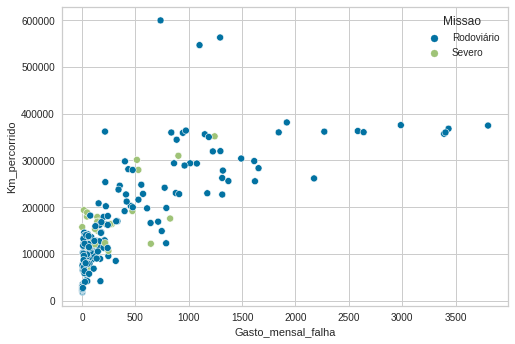

In [ ]:
condition = (base['Gasto_mensal_falha'] < 7000) & (base['Tipo_veiculo'] == 'L.A.-STRALIS 6X2')
x = base[condition]['Gasto_mensal_falha']
y = base[condition]['Km_percorrido']

# sns.scatterplot(x, y);

sns.scatterplot(data=base[condition], x=x, y=y, hue="Missao");

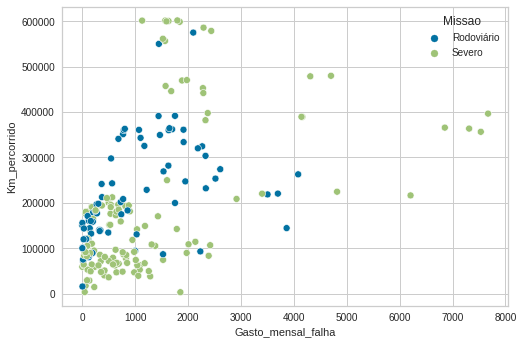

In [ ]:
condition = (base['Gasto_mensal_falha'] < 20000) & (base['Tipo_veiculo'] == 'L.A.-STRALIS 6X4')
x = base[condition]['Gasto_mensal_falha']
y = base[condition]['Km_percorrido']

# sns.scatterplot(x, y);

sns.scatterplot(data=base[condition], x=x, y=y, hue="Missao");

### PyCaret

In [31]:
# init setup
condition = (base['Gasto_mensal_falha'] < 20000)
s = setup(data = base[condition], target = 'Gasto_mensal_falha', session_id=42)

Description               Value
0                               session_id                  42
1                                   Target  Gasto_mensal_falha
2                            Original Data            (464, 5)
3                           Missing Values               False
4                         Numeric Features                   2
5                     Categorical Features                   2
6                         Ordinal Features               False
7                High Cardinality Features               False
8                  High Cardinality Method                None
9                    Transformed Train Set            (324, 4)
10                    Transformed Test Set            (140, 4)
11                      Shuffle Train-Test                True
12                     Stratify Train-Test               False
13                          Fold Generator               KFold
14                             Fold Number                  10
15                                CPU Jobs                  -1
16                                 Use GPU               False
17                          Log Experiment               False
18                         Experiment Name    reg-default-name
19                                     USI                6834
20                         Imputation Type              simple
21          Iterative Imputation Iteration                None
22                         Numeric Imputer                mean
23      Iterative Imputation Numeric Model                None
24                     Categorical Imputer            constant
25  Iterative Imputation Categorical Model                None
26           Unknown Categoricals Handling      least_frequent
27                               Normalize               False
28                        Normalize Method                None
29                          Transformation               False
30                   Transformation Method                None
31                                     PCA               False
32                              PCA Method                None
33                          PCA Components                None
34                     Ignore Low Variance               False
35                     Combine Rare Levels               False
36                    Rare Level Threshold                None
37                         Numeric Binning               False
38                         Remove Outliers               False
39                      Outliers Threshold                None
40                Remove Multicollinearity               False
41             Multicollinearity Threshold                None
42             Remove Perfect Collinearity                True
43                              Clustering               False
44                    Clustering Iteration                None
45                     Polynomial Features               False
46                       Polynomial Degree                None
47                    Trignometry Features               False
48                    Polynomial Threshold                None
49                          Group Features               False
50                       Feature Selection               False
51                Feature Selection Method             classic
52            Features Selection Threshold                None
53                     Feature Interaction               False
54                           Feature Ratio               False
55                   Interaction Threshold                None
56                        Transform Target               False
57                 Transform Target Method             box-cox

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Gasto_mensal_falha',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [32]:
# compare models
# best = compare_models(sort = 'F1')
best = compare_models()

Model       MAE           MSE       RMSE  \
rf                Random Forest Regressor  414.3644  6.456923e+05   743.2525   
et                  Extra Trees Regressor  400.3481  6.261900e+05   742.9427   
lightgbm  Light Gradient Boosting Machine  447.6674  7.353073e+05   791.0550   
gbr           Gradient Boosting Regressor  430.6511  7.750824e+05   806.5704   
ada                    AdaBoost Regressor  541.9205  7.614005e+05   832.6418   
knn                 K Neighbors Regressor  478.1839  8.204588e+05   866.2236   
llar         Lasso Least Angle Regression  537.9295  9.605835e+05   917.8578   
ridge                    Ridge Regression  541.9169  9.595994e+05   919.1540   
lasso                    Lasso Regression  541.9511  9.598213e+05   919.2629   
lr                      Linear Regression  542.2058  9.598262e+05   919.3417   
lar                Least Angle Regression  542.2058  9.598263e+05   919.3418   
en                            Elastic Net  538.4934  9.726646e+05   923.0775   
br                         Bayesian Ridge  543.7156  1.002916e+06   937.7044   
dt                Decision Tree Regressor  467.1900  9.102366e+05   876.9066   
huber                     Huber Regressor  503.1601  1.180616e+06  1000.4729   
omp           Orthogonal Matching Pursuit  607.0643  1.080707e+06   984.0633   
par          Passive Aggressive Regressor  660.6480  1.423992e+06  1143.6759   
dummy                     Dummy Regressor  788.7597  1.511994e+06  1165.4703   

              R2   RMSLE     MAPE  TT (Sec)  
rf        0.5671  0.9548   1.7013     0.191  
et        0.5373  0.9605   1.5229     0.152  
lightgbm  0.5186  1.0982   2.3673     0.092  
gbr       0.4949  1.0917   2.4317     0.044  
ada       0.4411  1.8823  13.0664     0.042  
knn       0.3835  1.1011   1.8594     0.012  
llar      0.3777  1.7772  10.8307     0.010  
ridge     0.3733  1.8011  11.8786     0.011  
lasso     0.3731  1.8012  11.8810     0.010  
lr        0.3729  1.8021  11.9347     0.009  
lar       0.3729  1.8021  11.9347     0.010  
en        0.3716  1.7622   9.2210     0.011  
br        0.3503  1.7462   7.3323     0.011  
dt        0.3482  1.0582   1.3785     0.013  
huber     0.2855  1.6044   5.6477     0.015  
omp       0.2570  1.7512   7.0164     0.011  
par      -0.0228  1.7009   7.0698     0.010  
dummy    -0.0233  2.5096  36.2618     0.011

INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [33]:
# Modelo Random Forest Regressor

modelo = create_model('rf')

MAE           MSE       RMSE      R2   RMSLE    MAPE
Fold                                                           
0     563.4723  1.332306e+06  1154.2554  0.6076  1.0925  1.8090
1     526.6501  1.231657e+06  1109.8002  0.2761  1.1110  2.4194
2     322.1428  3.924620e+05   626.4679  0.6685  0.8839  1.1594
3     368.7917  3.324273e+05   576.5651  0.8079  0.7250  0.7867
4     302.0989  1.954278e+05   442.0721  0.5272  0.7797  0.8920
5     647.1946  1.756746e+06  1325.4231  0.4404  0.9311  1.2497
6     323.7861  2.585207e+05   508.4493  0.7964  1.1692  4.5239
7     382.5379  3.221945e+05   567.6218  0.3943  1.0388  1.8092
8     349.0786  2.567297e+05   506.6851  0.5516  1.1052  1.7081
9     357.8910  3.784529e+05   615.1853  0.6012  0.7118  0.6561
Mean  414.3644  6.456923e+05   743.2525  0.5671  0.9548  1.7013
Std   113.5364  5.377261e+05   305.3981  0.1600  0.1634  1.0764

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [45]:
modelo = tune_model(modelo)

MAE           MSE       RMSE      R2   RMSLE    MAPE
Fold                                                           
0     551.2917  1.481486e+06  1217.1631  0.5636  1.3932  3.4613
1     440.5304  6.133082e+05   783.1400  0.6395  1.4558  5.3035
2     353.8484  4.032313e+05   635.0050  0.6594  1.0602  2.0379
3     415.4807  5.598291e+05   748.2173  0.6764  1.0182  1.9281
4     289.5276  2.113409e+05   459.7182  0.4887  1.0529  2.1787
5     700.9975  2.035063e+06  1426.5565  0.3517  1.2083  2.3824
6     306.1175  2.805487e+05   529.6685  0.7791  1.3800  7.0656
7     368.7603  3.113996e+05   558.0319  0.4146  1.3644  3.9662
8     394.1129  2.955150e+05   543.6130  0.4839  1.2339  2.8544
9     370.8667  3.839543e+05   619.6404  0.5954  0.8990  1.6024
Mean  419.1534  6.575677e+05   752.0754  0.5652  1.2066  3.2781
Std   116.9230  5.761575e+05   303.2330  0.1242  0.1810  1.6527

INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 5
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
# finalize a model
finalize_model(modelo)

In [47]:
## This function saves the transformation pipeline and a trained model object
# into the current working directory as a pickle file for later use.

# save pipeline
save_model(modelo, 'modelo_teste_1')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False), model_name=modelo_teste_1, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Gasto_mensal_falha',
              

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Gasto_mensal_falha',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numer...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=8,
                                        max_features='log2', max_leaf_nodes=None,
                                        max_samples

In [35]:
print(tuned_modelo)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [ ]:
# Salvando o modelo
# save_model(tuned_modelo, 'Precificacao_RandomForestRegressor-v1')


# save transformation pipeline and model 
#save_model('rf', model_name = 'Precificacao_RandomForestRegressor-v1')

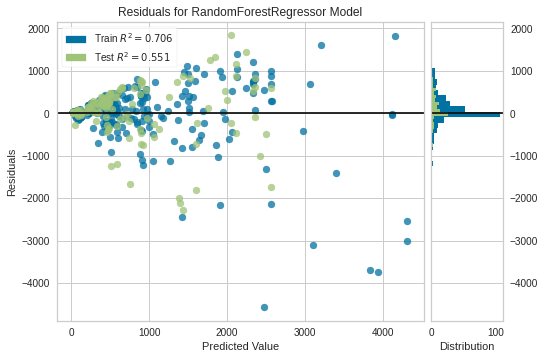

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_modelo)

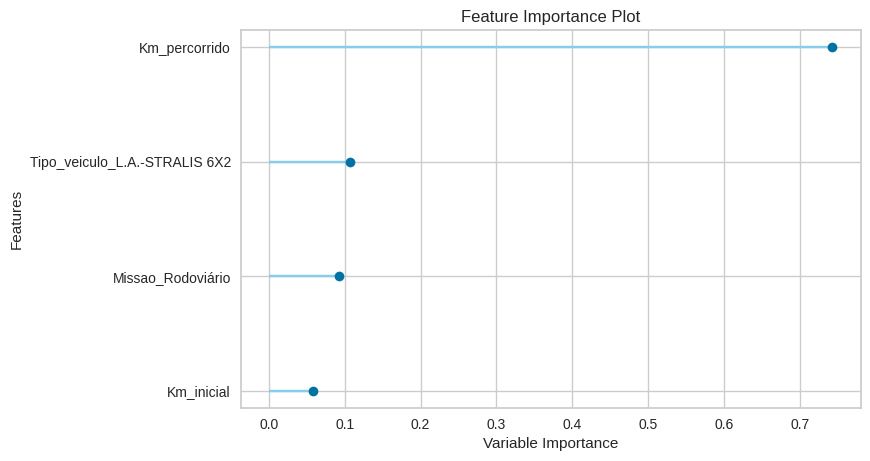

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [36]:
plot_model(tuned_modelo, plot = 'feature')

In [ ]:
base

Tipo_veiculo      Missao  Km_inicial  Km_percorrido  \
0    L.A.-STRALIS 6X2      Severo         0.0       279727.0   
1    L.A.-STRALIS 6X2  Rodoviário         1.0       563143.0   
2    L.A.-STRALIS 6X2  Rodoviário         1.0       599720.0   
3    L.A.-STRALIS 6X2      Severo         0.0       351630.0   
4    L.A.-STRALIS 6X2  Rodoviário         1.0       546801.0   
..                ...         ...         ...            ...   
461  L.A.-STRALIS 6X4  Rodoviário         0.0        15773.0   
462  L.A.-STRALIS 6X4  Rodoviário         0.0       119726.0   
463  L.A.-STRALIS 6X4  Rodoviário         0.0       100107.0   
464  L.A.-STRALIS 6X4      Severo         0.0       183606.0   
465  L.A.-STRALIS 6X4      Severo         0.0       220190.0   

     Gasto_mensal_falha  
0            527.596351  
1           1293.859583  
2            735.459092  
3           1242.410625  
4           1100.878958  
..                  ...  
461            6.144045  
462           27.047715  
463            4.198260  
464          254.229729  
465         3401.442634  

[466 rows x 5 columns]

In [15]:
import pickle


In [26]:
# modelo_carregado = pickle.load(open('Precificacao_RandomForestRegressor-v1.pkl','rb'))

# modelo_carregado

array(['Tipo_veiculo', 'Missao', 'Km_inicial', 'Km_percorrido'],
      dtype=object)

In [37]:
d = {'Tipo_veiculo': ['L.A.-STRALIS 6X4'], 'Missao': ['Rodoviário'],'Km_inicial':[0],	'Km_percorrido':[200000]}
input_data = pd.DataFrame(data=d)

In [10]:
#input_data=np.array([['L.A.-STRALIS 6X4', 'Rodoviário', 0,200000]])#.astype(np.float64)

In [38]:
input_data

Tipo_veiculo      Missao  Km_inicial  Km_percorrido
0  L.A.-STRALIS 6X4  Rodoviário           0         200000

In [39]:
#modelo_carregado.predict(input_data)

tuned_modelo.predict(input_data)

ValueError: ignored

In [ ]:
# open a file, where you ant to store the data
# file = open('Precificacao_RandomForestRegressor-v1.1.pkl', 'wb')
# # dump information to that file
# pickle.dump(tuned_modelo, file)

In [ ]:
modelo_carregado.predict(input_data)

ValueError: ignored

Tipo_veiculo      Missao  Km_inicial  Km_percorrido
0  L.A.-STRALIS 6X4  Rodoviário           0         200000

In [42]:
predict_model(tuned_modelo, data = input_data)


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Tipo_veiculo      Missao  Km_inicial  Km_percorrido       Label
0  L.A.-STRALIS 6X4  Rodoviário           0         200000  508.132505

In [22]:
d = {'Tipo_veiculo': ['L.A.-STRALIS 6X4'], 'Missao': ['Rodoviário'],'Km_inicial':[0],	'Km_percorrido':[200000]}
input_data = pd.DataFrame(data=d)

predicao_modelo_carregado = predict_model(modelo_carregado, data = input_data)
# tabela_predicao = predicao.iloc[:,3:]
valor_base_modelo_carregado = predicao_modelo_carregado.iloc[-1,-1]
predicao_modelo_carregado

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=['Tipo_veiculo' 'Missao' 'Km_inicial' 'Km_percorrido'], probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


AttributeError: ignored

In [43]:
d = {'Tipo_veiculo': ['L.A.-STRALIS 6X4'], 'Missao': ['Rodoviário'],'Km_inicial':[0],	'Km_percorrido':[200000]}
input_data = pd.DataFrame(data=d)

predicao = predict_model(tuned_modelo, data = input_data)
# tabela_predicao = predicao.iloc[:,3:]
valor_base = predicao.iloc[-1,-1]
predicao

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Tipo_veiculo      Missao  Km_inicial  Km_percorrido       Label
0  L.A.-STRALIS 6X4  Rodoviário           0         200000  508.132505

In [44]:
valor_base

508.13250511316375

In [ ]:
tabela_predicao.iloc[-1,-1]

508.13250511316375

In [ ]:
lista_mensalidade = []
lista_mensalidade.append(valor_base*(1-1/np.exp(1)))
lista_mensalidade.append(valor_base)

for i in range(8):
  lista_mensalidade.append( lista_mensalidade[i+1]*(1+1/np.exp(1)))

lista_mensalidade = [round(m,2) for m in lista_mensalidade]

lista_mensalidade

[321.2,
 508.13,
 695.06,
 950.76,
 1300.53,
 1778.97,
 2433.41,
 3328.62,
 4553.15,
 6228.16]

In [ ]:
anos_de_contrato = 5
KM_Anual = 200000

lista_fator = [i*0.5 for i in range(1,2*anos_de_contrato+1)]
lista_meses = [str(int(12*i))+'M' for i in lista_fator]
lista_km    = [int(KM_Anual*i) for i in lista_fator]

lista_preco_total = [round(m*12*f,2) for f,m in zip(lista_fator,lista_mensalidade)]
lista_preco_km    = [ round(p/k,4) for p,k in zip(lista_preco_total,lista_km)]

In [ ]:
anos_de_contrato = 5
KM_Anual = 200000

lista_fator = [i*0.5 for i in range(1,2*anos_de_contrato+1)]
lista_meses = [str(int(12*i))+'M' for i in lista_fator]
lista_km    = [int(KM_Anual*i) for i in lista_fator]

lista_preco_total = [round(m*12*f,2) for f,m in zip(lista_fator,lista_mensalidade)]
lista_preco_km    = [ round(p/k,4) for p,k in zip(lista_preco_total,lista_km)]



dados = {'Meses':lista_meses,
         'Km rodados':lista_km,
         'Mensalidade':lista_mensalidade,
         'Preço Total':lista_preco_total,
         'Preço por Km':lista_preco_km
        }
pd.DataFrame(dados)



Meses  Km rodados  Mensalidade  Preço Total  Preço por Km
0    6M      100000       321.20      1927.20        0.0193
1   12M      200000       508.13      6097.56        0.0305
2   18M      300000       695.06     12511.08        0.0417
3   24M      400000       950.76     22818.24        0.0570
4   30M      500000      1300.53     39015.90        0.0780
5   36M      600000      1778.97     64042.92        0.1067
6   42M      700000      2433.41    102203.22        0.1460
7   48M      800000      3328.62    159773.76        0.1997
8   54M      900000      4553.15    245870.10        0.2732
9   60M     1000000      6228.16    373689.60        0.3737

In [ ]:
pd.DataFrame(list(lista_meses,lista_km,mensalidades,lista_preco_total,lista_preco_km),
               columns =['Meses', 'Km rodados','Mensalidade', 'Preço Total','Preço por Km'])

TypeError: ignored

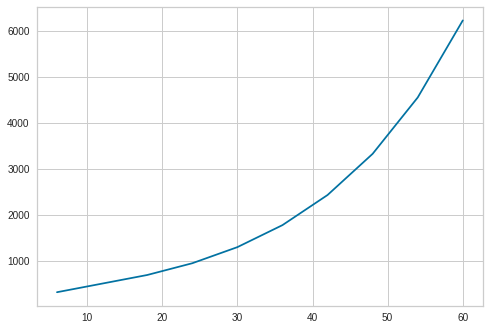

In [ ]:
#data =  [1,5,3,2,6] * 2
tempo = range(6,66,6)

sns.lineplot(tempo,precos_semestre);

In [ ]:
precos_semestre = [a*10*math.tanh(b/100) for b in list(range(6,66,6))]


sns.lineplot(tempo,precos_semestre);

In [ ]:
precos_semestre

[304.51417366163025,
 606.8489236966033,
 904.8867760903361,
 1196.6304512984955,
 1480.2540750312105,
 1754.1447192643775,
 2016.932547254722,
 2267.5088351595605,
 2505.0321044158904,
 2728.9234178787697]

### Modelos separados por tipo de veículo

In [ ]:
# condition = (base['Gasto_mensal_falha'] < 7000) & (base['Tipo_veiculo'] == 'L.A.-STRALIS 6X2')
# base[condition].iloc[:,1:5]

#### Modelo 6x2

In [ ]:
condition = (base['Gasto_mensal_falha'] < 7000) & (base['Tipo_veiculo'] == 'L.A.-STRALIS 6X2')

s_6x2 = setup(data = base[condition].iloc[:,1:5], target = 'Gasto_mensal_falha', session_id=42)

Description               Value
0                               session_id                  42
1                                   Target  Gasto_mensal_falha
2                            Original Data            (248, 4)
3                           Missing Values               False
4                         Numeric Features                   2
5                     Categorical Features                   1
6                         Ordinal Features               False
7                High Cardinality Features               False
8                  High Cardinality Method                None
9                    Transformed Train Set            (173, 3)
10                    Transformed Test Set             (75, 3)
11                      Shuffle Train-Test                True
12                     Stratify Train-Test               False
13                          Fold Generator               KFold
14                             Fold Number                  10
15                                CPU Jobs                  -1
16                                 Use GPU               False
17                          Log Experiment               False
18                         Experiment Name    reg-default-name
19                                     USI                913a
20                         Imputation Type              simple
21          Iterative Imputation Iteration                None
22                         Numeric Imputer                mean
23      Iterative Imputation Numeric Model                None
24                     Categorical Imputer            constant
25  Iterative Imputation Categorical Model                None
26           Unknown Categoricals Handling      least_frequent
27                               Normalize               False
28                        Normalize Method                None
29                          Transformation               False
30                   Transformation Method                None
31                                     PCA               False
32                              PCA Method                None
33                          PCA Components                None
34                     Ignore Low Variance               False
35                     Combine Rare Levels               False
36                    Rare Level Threshold                None
37                         Numeric Binning               False
38                         Remove Outliers               False
39                      Outliers Threshold                None
40                Remove Multicollinearity               False
41             Multicollinearity Threshold                None
42             Remove Perfect Collinearity                True
43                              Clustering               False
44                    Clustering Iteration                None
45                     Polynomial Features               False
46                       Polynomial Degree                None
47                    Trignometry Features               False
48                    Polynomial Threshold                None
49                          Group Features               False
50                       Feature Selection               False
51                Feature Selection Method             classic
52            Features Selection Threshold                None
53                     Feature Interaction               False
54                           Feature Ratio               False
55                   Interaction Threshold                None
56                        Transform Target               False
57                 Transform Target Method             box-cox

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Gasto_mensal_falha',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best = compare_models()

Model       MAE          MSE      RMSE  \
lightgbm  Light Gradient Boosting Machine  186.7984  166530.6154  374.1007   
llar         Lasso Least Angle Regression  242.3238  188380.8678  396.2051   
br                         Bayesian Ridge  244.0944  189506.6542  396.0244   
en                            Elastic Net  245.6520  189613.9438  397.8992   
ridge                    Ridge Regression  245.3655  188545.9797  399.0656   
lasso                    Lasso Regression  245.5227  188655.4062  399.2475   
lr                      Linear Regression  245.7640  188666.2957  399.4632   
lar                Least Angle Regression  245.7640  188666.3070  399.4633   
knn                 K Neighbors Regressor  198.1659  179130.2188  394.0334   
omp           Orthogonal Matching Pursuit  249.5436  191876.8988  402.1982   
rf                Random Forest Regressor  198.0770  207601.6279  417.9518   
huber                     Huber Regressor  234.1527  262807.4672  464.0443   
ada                    AdaBoost Regressor  231.5693  245060.3513  454.5370   
et                  Extra Trees Regressor  211.5187  245883.0753  458.2245   
gbr           Gradient Boosting Regressor  220.6929  277532.3635  487.7051   
dt                Decision Tree Regressor  242.8726  315411.2490  517.5694   
dummy                     Dummy Regressor  396.1028  371440.1500  573.9444   
par          Passive Aggressive Regressor  345.8971  385706.1737  576.6687   

              R2   RMSLE     MAPE  TT (Sec)  
lightgbm  0.4962  0.9601   1.9091     0.100  
llar      0.4958  1.8512   9.7320     0.012  
br        0.4906  1.8507  11.0634     0.012  
en        0.4837  1.8581  11.1329     0.013  
ridge     0.4815  1.8602  10.2641     0.012  
lasso     0.4810  1.8614  10.2664     0.014  
lr        0.4803  1.8680  10.1984     0.340  
lar       0.4803  1.8680  10.1984     0.018  
knn       0.4794  0.9165   1.8183     0.015  
omp       0.4682  1.8599  11.1686     0.013  
rf        0.3951  0.8951   1.6285     0.184  
huber     0.3456  1.5444   5.4765     0.022  
ada       0.3315  1.6099   6.6052     0.052  
et        0.1957  0.9137   1.6756     0.155  
gbr       0.0810  1.0406   2.3317     0.043  
dt       -0.0668  1.0298   1.5376     0.014  
dummy    -0.0810  2.4873  26.3809     0.013  
par      -0.2956  2.1586   7.1577     0.014

INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................



Criando o modelo

Usaremos aquele que apresentou o melhor R^2: Light Gradient Boosting Machine

In [ ]:
modelo_6x2 = create_model('lightgbm')

MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     249.6300  197411.4400  444.3101  0.3962  0.8318  1.1535
1     151.9060   53292.1054  230.8508  0.7992  1.2353  2.4545
2     225.4109  116128.7651  340.7767  0.3944  1.0477  1.8880
3      95.7764   24566.9979  156.7386  0.8926  0.8163  1.2682
4     224.8008  308548.4454  555.4714  0.5904  1.0607  4.9081
5     162.0670   65511.8135  255.9528  0.6327  1.1319  2.4762
6     134.1978   58710.7332  242.3030  0.5281  0.8360  1.1523
7     144.6766   82455.2421  287.1502 -0.2373  0.8053  1.2627
8     230.2896  315799.6875  561.9606  0.5259  0.9367  1.2235
9     249.2285  442880.9244  665.4930  0.4402  0.8997  1.3036
Mean  186.7984  166530.6154  374.1007  0.4962  0.9601  1.9091
Std    52.2754  135716.2509  163.0315  0.2898  0.1427  1.1146

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
tuned_modelo_6x2 = tune_model(modelo_6x2)

MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     226.3980  169742.4694  411.9981  0.4808  0.8556  1.2964
1     133.5794   44268.3792  210.4005  0.8332  1.2467  2.1248
2     197.9460  104055.6612  322.5766  0.4573  0.8864  1.1778
3      93.7923   25716.3158  160.3631  0.8875  0.7868  1.0903
4     213.9291  284109.1049  533.0189  0.6229  1.1254  5.6527
5     173.3250   71527.3536  267.4460  0.5990  1.1969  3.0598
6     164.2298   73491.2096  271.0926  0.4093  0.8543  1.2407
7     154.7146  100759.4078  317.4262 -0.5120  0.8589  1.3225
8     216.5806  296412.7309  544.4380  0.5550  1.5090  0.9349
9     251.6275  437162.5703  661.1827  0.4474  0.7891  0.9337
Mean  182.6122  160724.5203  369.9943  0.4780  1.0109  1.8834
Std    45.3273  128178.2246  154.3657  0.3635  0.2320  1.4018

INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 4
INFO:logs:LGBMRegressor(bagging_fraction=0.8, bagging_freq=7, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=16, min_child_weight=0.001, min_split_gain=0.7,
              n_estimators=100, n_jobs=-1, num_leaves=90, objective=None,
              random_state=42, reg_alpha=1, reg_lambda=3, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
print(tuned_modelo_6x2)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=7, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=16, min_child_weight=0.001, min_split_gain=0.7,
              n_estimators=100, n_jobs=-1, num_leaves=90, objective=None,
              random_state=42, reg_alpha=1, reg_lambda=3, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


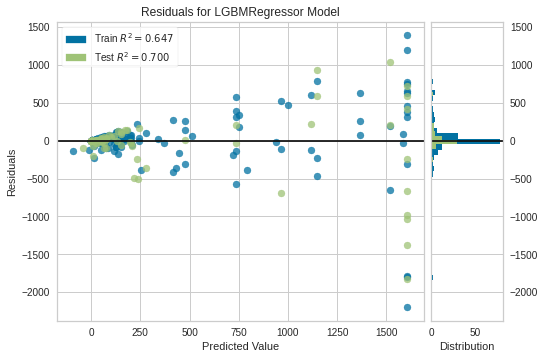

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_modelo_6x2)

In [ ]:
plot_model(tuned_modelo_6x2, plot = 'error')

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_modelo_6x2, plot = 'feature')

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
d = {'Missao': ['Rodoviário'],'Km_inicial':[0],	'Km_percorrido':[100000]}
input_data = pd.DataFrame(data=d)

predict_model(tuned_modelo_6x2, data = input_data)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=7, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=16, min_child_weight=0.001, min_split_gain=0.7,
              n_estimators=100, n_jobs=-1, num_leaves=90, objective=None,
              random_state=42, reg_alpha=1, reg_lambda=3, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Missao  Km_inicial  Km_percorrido      Label
0  Rodoviário           0         100000  48.483279

In [ ]:
a = 478.742237/2

print(a,2*a,5*a,8*a,13*a,21*a,34*a)

239.3711185 478.742237 1196.8555925 1914.968948 3111.8245405 5026.7934884999995 8138.618029


In [ ]:
(478.742237/6)*np.log(478.742237*6) , (478.742237/7)*np.log(478.742237)

(nan, 422.0565794951202)

tanh(x) = [e^(2x)-1]/[e^(2x)+1]

In [ ]:
[b*a for b in list(range(6,66,6))]

[290.899674,
 581.799348,
 872.699022,
 1163.598696,
 1454.49837,
 1745.398044,
 2036.297718,
 2327.197392,
 2618.0970660000003,
 2908.99674]

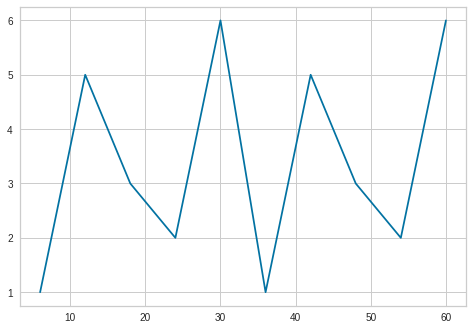

In [ ]:
data =  [1,5,3,2,6] * 2
tempo = range(6,66,6)

sns.lineplot(tempo,data);

In [ ]:
a = 48.483279
print(a + (np.exp(2*6*a)-1) / (np.exp(2*6*a)+1))

49.483279


In [ ]:
[(a + (np.exp(2*b*a)-1) / (np.exp(2*b*a)+1)) for b in list(range(6,66,6))]


[49.483279, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
import math




[a*b*math.tanh(b/(a)) for b in list(range(6,66,6))]

[35.817338260215976,
 141.12982030237998,
 309.89114064464155,
 533.1475466475091,
 800.3683768756723,
 1100.766175727699,
 1424.3457788725623,
 1762.5634268468345,
 2108.606558033971,
 2457.382408728773]

In [ ]:
(a + (np.exp(2*12*a)-1) / (np.exp(2*12*a)+1))

nan

In [ ]:
import numpy as np 

inp_arr = [6, 12, 18, 24, 36, 48, 54, 60] 
print ("Array input elements:\n", inp_arr) 

res_arr = np.log(478.742237*inp_arr) / inp_arr
print ("Resultant array elements:\n", res_arr) 

Array input elements:
 [6, 12, 18, 24, 36, 48, 54, 60]


TypeError: ignored

In [ ]:



2, 3, 5, 8, 13, 21, 34, 55, 89

#### Modelo 6x4

In [ ]:
condition = (base['Gasto_mensal_falha'] < 20000) & (base['Tipo_veiculo'] == 'L.A.-STRALIS 6X4')

s_6x4 = setup(data = base[condition].iloc[:,1:5], target = 'Gasto_mensal_falha', session_id=42)

Description               Value
0                               session_id                  42
1                                   Target  Gasto_mensal_falha
2                            Original Data            (215, 4)
3                           Missing Values               False
4                         Numeric Features                   2
5                     Categorical Features                   1
6                         Ordinal Features               False
7                High Cardinality Features               False
8                  High Cardinality Method                None
9                    Transformed Train Set            (150, 3)
10                    Transformed Test Set             (65, 3)
11                      Shuffle Train-Test                True
12                     Stratify Train-Test               False
13                          Fold Generator               KFold
14                             Fold Number                  10
15                                CPU Jobs                  -1
16                                 Use GPU               False
17                          Log Experiment               False
18                         Experiment Name    reg-default-name
19                                     USI                cd65
20                         Imputation Type              simple
21          Iterative Imputation Iteration                None
22                         Numeric Imputer                mean
23      Iterative Imputation Numeric Model                None
24                     Categorical Imputer            constant
25  Iterative Imputation Categorical Model                None
26           Unknown Categoricals Handling      least_frequent
27                               Normalize               False
28                        Normalize Method                None
29                          Transformation               False
30                   Transformation Method                None
31                                     PCA               False
32                              PCA Method                None
33                          PCA Components                None
34                     Ignore Low Variance               False
35                     Combine Rare Levels               False
36                    Rare Level Threshold                None
37                         Numeric Binning               False
38                         Remove Outliers               False
39                      Outliers Threshold                None
40                Remove Multicollinearity               False
41             Multicollinearity Threshold                None
42             Remove Perfect Collinearity                True
43                              Clustering               False
44                    Clustering Iteration                None
45                     Polynomial Features               False
46                       Polynomial Degree                None
47                    Trignometry Features               False
48                    Polynomial Threshold                None
49                          Group Features               False
50                       Feature Selection               False
51                Feature Selection Method             classic
52            Features Selection Threshold                None
53                     Feature Interaction               False
54                           Feature Ratio               False
55                   Interaction Threshold                None
56                        Transform Target               False
57                 Transform Target Method             box-cox

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Gasto_mensal_falha',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best = compare_models()

Model        MAE           MSE       RMSE  \
lightgbm  Light Gradient Boosting Machine   630.3973  8.911676e+05   899.5874   
rf                Random Forest Regressor   597.9969  8.217472e+05   852.7981   
huber                     Huber Regressor   673.0686  1.539968e+06  1116.0110   
knn                 K Neighbors Regressor   666.0004  1.077401e+06   997.0275   
gbr           Gradient Boosting Regressor   616.2809  1.001379e+06   945.5452   
br                         Bayesian Ridge   759.6401  1.427459e+06  1114.6127   
en                            Elastic Net   752.3592  1.410911e+06  1112.0497   
ada                    AdaBoost Regressor   668.9726  1.062931e+06   979.0148   
omp           Orthogonal Matching Pursuit   788.7174  1.451496e+06  1132.5480   
llar         Lasso Least Angle Regression   755.1340  1.409712e+06  1122.5850   
ridge                    Ridge Regression   754.0012  1.408384e+06  1122.4490   
lasso                    Lasso Regression   755.0208  1.409633e+06  1123.4467   
lr                      Linear Regression   755.2605  1.409678e+06  1123.6607   
lar                Least Angle Regression   755.2604  1.409678e+06  1123.6607   
et                  Extra Trees Regressor   617.7245  9.561111e+05   917.9261   
dt                Decision Tree Regressor   656.0834  1.125520e+06   996.0566   
dummy                     Dummy Regressor   924.7664  1.852751e+06  1280.9929   
par          Passive Aggressive Regressor  1407.0967  6.261745e+06  2045.7581   

              R2   RMSLE     MAPE  TT (Sec)  
lightgbm  0.3467  1.1597   3.1912     0.021  
rf        0.2623  1.1545   3.3935     0.192  
huber     0.2073  1.2466   4.0580     0.025  
knn       0.1759  1.2772   4.9303     0.016  
gbr       0.1423  1.1169   2.9153     0.039  
br        0.1036  1.3712   6.4051     0.011  
en        0.0920  1.3371   5.7539     0.014  
ada       0.0587  1.3831   6.8213     0.047  
omp       0.0431  1.4197   7.2275     0.013  
llar      0.0392  1.3090   5.1640     0.012  
ridge     0.0361  1.2951   4.9720     0.012  
lasso     0.0324  1.2951   4.9483     0.013  
lr        0.0313  1.2949   4.9375     0.011  
lar       0.0313  1.2949   4.9374     0.011  
et        0.0200  1.1981   3.0239     0.158  
dt       -0.1092  1.3436   2.9690     0.013  
dummy    -0.1935  1.6448  10.9233     0.012  
par      -7.8814  1.5547   4.6204     0.014

INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
modelo_6x4 = create_model('lightgbm')

MAE           MSE       RMSE      R2   RMSLE    MAPE
Fold                                                           
0     468.0291  3.897983e+05   624.3383 -0.4233  0.8582  1.3645
1     682.4886  7.815772e+05   884.0685  0.3772  0.6651  0.7050
2     395.8307  2.039580e+05   451.6171  0.5825  1.3934  5.9928
3     675.8053  7.711221e+05   878.1356  0.5650  1.1642  1.3872
4     535.9052  4.649958e+05   681.9060  0.3776  1.4211  7.3466
5     667.3809  1.519530e+06  1232.6923  0.5274  1.1759  3.7083
6     587.8163  5.128106e+05   716.1079 -0.1402  1.0360  1.6082
7     596.9309  1.186553e+06  1089.2899  0.5937  1.2886  2.9864
8     734.7232  9.687178e+05   984.2346  0.5540  1.5026  4.7967
9     959.0630  2.112614e+06  1453.4832  0.4529  1.0919  2.0159
Mean  630.3973  8.911676e+05   899.5874  0.3467  1.1597  3.1912
Std   147.7481  5.527080e+05   286.1996  0.3291  0.2475  2.1134

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
tuned_modelo_6x4 = tune_model(modelo_6x4)

MAE           MSE       RMSE      R2   RMSLE     MAPE
Fold                                                            
0     404.5509  2.156290e+05   464.3586  0.2126  0.9559   1.6580
1     501.9136  5.575056e+05   746.6630  0.5557  0.9566   0.5342
2     443.8998  3.111428e+05   557.8018  0.3631  1.5256  12.2037
3     690.5821  8.821636e+05   939.2356  0.5024  1.2714   1.5102
4     643.1775  9.525176e+05   975.9701 -0.2749  1.4943   9.3033
5     774.5505  1.518757e+06  1232.3786  0.5277  1.2755   5.4290
6     551.8759  3.814622e+05   617.6263  0.1518  1.0991   1.7938
7     545.4706  6.133377e+05   783.1588  0.7900  1.6897   3.8392
8     715.8080  8.543808e+05   924.3272  0.6067  1.4087   4.0587
9     995.7507  2.071241e+06  1439.1808  0.4636  1.1857   2.5280
Mean  626.7580  8.358138e+05   868.0701  0.3899  1.2862   4.2858
Std   167.5964  5.479143e+05   286.8242  0.2833  0.2327   3.5694

INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 4
INFO:logs:LGBMRegressor(bagging_fraction=0.8, bagging_freq=3, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.2, max_depth=-1,
              min_child_samples=6, min_child_weight=0.001, min_split_gain=0.6,
              n_estimators=100, n_jobs=-1, num_leaves=30, objective=None,
              random_state=42, reg_alpha=0.001, reg_lambda=5, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
d = {'Missao': ['Rodoviário'],'Km_inicial':[0],	'Km_percorrido':[100000]}
input_data = pd.DataFrame(data=d)

predict_model(tuned_modelo_6x4, data = input_data)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=3, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.2, max_depth=-1,
              min_child_samples=6, min_child_weight=0.001, min_split_gain=0.6,
              n_estimators=100, n_jobs=-1, num_leaves=30, objective=None,
              random_state=42, reg_alpha=0.001, reg_lambda=5, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Missao  Km_inicial  Km_percorrido      Label
0  Rodoviário           0         100000 -60.342248